In [1]:
import gurobipy as gp
from gurobipy import GRB
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import pickle
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
with open("travel_time.pkl", "rb") as file:
    travel_time = pickle.load(file)
D = np.zeros((26,26,26))
c_matrix= travel_time.copy()
for i in range(26):
    for j in range(26):
        for k in range(26):
            D[i,j,k] = min(c_matrix[i][k]+c_matrix[k][i],c_matrix[j][k]+c_matrix[k][j],c_matrix[j][k]+c_matrix[k][i]-c_matrix[j][i],c_matrix[i][k]+c_matrix[k][j]-c_matrix[i][j])
            if D[i,j,k]<0:
                D[i,j,k]=0

In [3]:
#dfbase = pd.read_pickle('base.pkl')
#dfbaset = pd.read_pickle('base_4time.pkl')#update
#dfbasetherd = pd.read_pickle('vars_basecase_time_herd.pkl')
#dfod = pd.read_pickle('base_od.pkl')
#dfodt = pd.read_pickle('base_od_4time.pkl')#update
#dfherd = pd.read_pickle('vars_basecase_od_time_herd.pkl')
#dfrand = pd.read_pickle('vars_basecase_od_time_herd_case60100.pkl')
dfrand = pd.read_pickle('base_od_4time_prvweighted.pkl')

districts = {0: 'Antelope Valley', 
             1: 'East Valley', 
             2: 'Glendale', 
             3: 'San Fernando', 
             4: 'West Valley',
             5: 'Alhambra', 
             6: 'El Monte', 
             7: 'Foothill', 
             8: 'Pasadena', 
             9: 'Pomona',
             10: 'Central', 
             11: 'Hollywood-Wilshire', 
             12: 'Northeast', 
             13: 'West',
             14: 'Compton', 
             15: 'South', 
             16: 'Southeast', 
             17: 'Southwest',
             18: 'Bellflower', 
             19: 'East Los Angeles', 
             20: 'San Antonio', 
             21: 'Whittier',
             22: 'Harbor', 
             23: 'Inglewood', 
             24: 'Long Beach', 
             25: 'Torrance'}


In [4]:
#dfxbase = dfbase[dfbase.name=='x']
#dfybase = dfbase[dfbase.name=='y']
#dfzbase = dfbase[dfbase.name=='z']
#dfxbaset = dfbaset[dfbaset.name=='x']
#dfybaset = dfbaset[dfbaset.name=='y']
#dfzbaset = dfbaset[dfbaset.name=='z']
#dfxbasetherd = dfbasetherd[dfbasetherd.name=='x']
#dfybasetherd = dfbasetherd[dfbasetherd.name=='y']
#dfzbasetherd = dfbasetherd[dfbasetherd.name=='z']
#dfxod = dfod[dfod.name=='x']
#dfyod = dfod[dfod.name=='y']
#dfzod = dfod[dfod.name=='z']
#dfxodt = dfodt[dfodt.name=='x']
#dfyodt = dfodt[dfodt.name=='y']
#dfzodt = dfodt[dfodt.name=='z']
#dfxherd = dfherd[dfherd.name=='x']
#dfyherd = dfherd[dfherd.name=='y']
#dfzherd = dfherd[dfherd.name=='z']
dfxrand = dfrand[dfrand.name=='x']
dfyrand = dfrand[dfrand.name=='y']
dfzrand = dfrand[dfrand.name=='z']

In [5]:
total_pop = [420697,443569,344450,526877,899111,339399,419797,308499,140361,547523,354750,479505,287613,666399,278815,193899,166374,379199,356465,195082,407864,321720,201739,411617,469439,465691]


In [6]:
score = 0
for t in range(6):
    for i in range(26):
        for j in range(26):
            y_v = dfrand[dfrand.i==i]
            y_v = y_v[y_v.j==j]
            y_v = y_v[y_v.t==t]
            y_v = y_v.value.values[0]
            score += y_v*(2*travel_time[i][j])
            for k in range(26):
                z_v = dfzrand[dfzrand.i==i]
                z_v = z_v[z_v.j==j]
                z_v = z_v[z_v.k==k]
                z_v = z_v[z_v.t==t]
                z_v = z_v.value.values[0]
                score += z_v*D[i][j][k]

In [7]:
score


221293932.77000004

# Base model + OD + 6 periods + 60% herd imunity

In [8]:
flow_matrix = np.zeros((26,26,6))
flow_matrix_od = np.zeros((26,26,26,6))
for t in range(6):
    for i in range(26):
        for j in range(26):
            new = dfyrand[dfyrand['i']==i]
            new = new[new['j']==j]
            new = new[new['t']==t]
            flow_matrix[i,j,t] = sum(new.value)
            for k in range(26):
                new2 = dfzrand[dfzrand['i']==i]
                new2 = new2[new2['j']==j]
                new2 = new2[new2['k']==k]
                new2 = new2[new2['t']==t]
                flow_matrix_od[i,j,k,t] = sum(new2.value)
sites = list(dfxrand[dfxrand.value==1].i)

indices = np.arange(len(districts))
index_names = [districts[i] for i in indices]
    
for site in sites:
    print(districts[site])
    print(np.sum(flow_matrix[:,site,:])+np.sum(flow_matrix_od[:,:,site,:]))
print('more smooth')

San Fernando
1429129.0
West Valley
1221616.0
El Monte
1643030.0
Central
1927709.0
South
2000000.0
Bellflower
1804970.0
more smooth


In [9]:
#print(np.where(flow_matrix[0]>0)[0][0])
first = 0
second = 0
third = 0
fourth = 0
fifth = 0
for site in list(districts.keys()):
    candiates = travel_time[site,:].copy()
    for vac_site in sites:
        candiates[vac_site] -= 1000
    sorted_indices = np.argsort(candiates)
    index1 = sorted_indices[0]
    index2 = sorted_indices[1]
    index3 = sorted_indices[2]
    index4 = sorted_indices[4]
    index5 = sorted_indices[5]
    percentage = 100*np.sum(flow_matrix[site,index1,:])/np.sum(flow_matrix[site])
    percentage2 = 100*np.sum(flow_matrix[site,index2,:])/np.sum(flow_matrix[site])
    percentage3 = 100*np.sum(flow_matrix[site,index3,:])/np.sum(flow_matrix[site])
    first += np.sum(flow_matrix[site,index1,:])
    second += np.sum(flow_matrix[site,index2,:])
    third += np.sum(flow_matrix[site,index3,:])
    fourth += np.sum(flow_matrix[site,index4,:])
    fifth += np.sum(flow_matrix[site,index5,:])
    if percentage>100:
        print(districts[site])
        print(site)
        #print('preferred',districts[np.argmin(travel_time[site,:])])
        #print('actual',districts[np.where(flow_matrix[site]>0)[0][0]])
        print(percentage,'% go to closest vaccination site')
        print(percentage2,'% go to second closest vaccination site')
        print(percentage3,'% go to third closest vaccination site')


In [10]:
with open("travel_time.pkl", "rb") as file:
    c_m_v = pickle.load(file)

In [11]:
first_od = 0
second_od = 0
third_od = 0
fourth_od = 0
fifth_od = 0
first_odo = 0
second_odo = 0
third_odo = 0
fourth_odo = 0
fifth_odo = 0
first_odd = 0
second_odd = 0
third_odd = 0
fourth_odd = 0
fifth_odd = 0
for site in list(districts.keys()):
    for site2 in list(districts.keys()):
        candiates2 = D[site,site2,:].copy()
        candiates2[site] = -1
        for vac_site in sites:
            candiates2[vac_site] -= 1000
        sorted_indices = np.argsort(candiates2)
        index1 = sorted_indices[0]
        index2 = sorted_indices[1]
        index3 = sorted_indices[2]
        index4 = sorted_indices[3]
        index5 = sorted_indices[4]
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route = 100*(np.sum(flow_matrix_od[site,site2,index1]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route = 100
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route2 = 100*(np.sum(flow_matrix_od[site,site2,index2]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route2 = 100
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route3 = 100*(np.sum(flow_matrix_od[site,site2,index3]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route3 = 100  
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route4 = 100*(np.sum(flow_matrix_od[site,site2,index4]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route4 = 100 
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route5 = 100*(np.sum(flow_matrix_od[site,site2,index5]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route5 = 100 
        first_od += np.sum(flow_matrix_od[site,site2,index1])
        if c_m_v[site,index1]<c_m_v[site2,index1]:
            first_odo += np.sum(flow_matrix_od[site,site2,index1])
        else:
            first_odd += np.sum(flow_matrix_od[site,site2,index1])
        if index2 in sites:
            first_od += np.sum(flow_matrix_od[site,site2,index2])
            if c_m_v[site,index2]<c_m_v[site2,index2]:
                first_odo += np.sum(flow_matrix_od[site,site2,index2])
            else:
                first_odd += np.sum(flow_matrix_od[site,site2,index2])
            second_od += np.sum(flow_matrix_od[site,site2,index3])
            if c_m_v[site,index2]<c_m_v[site2,index3]:
                second_odo += np.sum(flow_matrix_od[site,site2,index3])
            else:
                second_odd += np.sum(flow_matrix_od[site,site2,index3])
            third_od += np.sum(flow_matrix_od[site,site2,index4])
            if c_m_v[site,index3]<c_m_v[site2,index4]:
                third_odo += np.sum(flow_matrix_od[site,site2,index4])
            else:
                third_odd += np.sum(flow_matrix_od[site,site2,index4])
            fourth_od += np.sum(flow_matrix_od[site,site2,index5])
            if c_m_v[site,index4]<c_m_v[site2,index5]:
                fourth_odo += np.sum(flow_matrix_od[site,site2,index5])
            else:
                fourth_odd += np.sum(flow_matrix_od[site,site2,index5])
        else:
            second_od += np.sum(flow_matrix_od[site,site2,index2])
            if c_m_v[site,index2]<c_m_v[site2,index2]:
                second_odo += np.sum(flow_matrix_od[site,site2,index2])
            else:
                second_odd += np.sum(flow_matrix_od[site,site2,index2])
            third_od += np.sum(flow_matrix_od[site,site2,index3])
            if c_m_v[site,index3]<c_m_v[site2,index3]:
                third_odo += np.sum(flow_matrix_od[site,site2,index3])
            else:
                third_odd += np.sum(flow_matrix_od[site,site2,index3])
            fourth_od += np.sum(flow_matrix_od[site,site2,index4])
            if c_m_v[site,index4]<c_m_v[site2,index4]:
                fourth_odo += np.sum(flow_matrix_od[site,site2,index4])
            else:
                fourth_odd += np.sum(flow_matrix_od[site,site2,index4])
            fifth_od += np.sum(flow_matrix_od[site,site2,index5])
            if c_m_v[site,index5]<c_m_v[site2,index5]:
                fifth_odo += np.sum(flow_matrix_od[site,site2,index5])
            else:
                fifth_odd += np.sum(flow_matrix_od[site,site2,index5])
        if percentage_route>100:
            print('OD pair '+districts[site]+' to '+districts[site2])
            if percentage_route>0:
                print(percentage_route,'% go to closest vaccination site')
            if percentage_route2>0:
                print(percentage_route2,'% go to second closest vaccination site')
            if percentage_route3>0:
                print(percentage_route3,'% go to third closest vaccination site')
            if percentage_route4>0:
                print(percentage_route4,'% go to fourth closest vaccination site')
            if percentage_route5>0:
                print(percentage_route5,'% go to fourth closest vaccination site')

In [12]:
#print('Overall,\n\n for non-communters,\n',100*first/np.sum(flow_matrix),'% people go to closest vaccine site;\n',100*second/np.sum(flow_matrix),'% people go to second closest vaccine site;\n',100*third/np.sum(flow_matrix),'% people go to third closest vaccine site;\n')
#print('for communters,\n',100*first_od/np.sum(flow_matrix_od),'% people go to closest vaccine site;\n',100*second_od/np.sum(flow_matrix_od),'% people go to second closest vaccine site;\n',100*third_od/np.sum(flow_matrix_od),'% people go to third closest vaccine site;\n',100*fifth_od/np.sum(flow_matrix_od),'% people go to fifth closest vaccine site;\n')
print(100*(first+first_odo)/sum(total_pop),'% people go to closest vaccine site;')
print(100*(first_odd)/sum(total_pop),'% people go to closest (D) vaccine site;\n')
print(100*(second+second_odo)/sum(total_pop),'% people go to 2nd closest vaccine site;')
print(100*(second_odd)/sum(total_pop),'% people go to 2nd closest (D) vaccine site;\n')
print(100*(third+third_odo)/sum(total_pop),'% people go to 3rd closest vaccine site;')
print(100*(third_odd)/sum(total_pop),'% people go to 3rd closest (D) vaccine site;\n')
print(100*(fourth+fourth_odo)/sum(total_pop),'% people go to 4th closest vaccine site;')
print(100*(fourth_odd)/sum(total_pop),'% people go to 4th closest (D) vaccine site;\n')
print(100*(fifth+fifth_odo)/sum(total_pop),'% people go to 5th closest vaccine site;')
print(100*(fifth_odd)/sum(total_pop),'% people go to 5th closest (D) vaccine site;\n')


64.9265433222952 % people go to closest vaccine site;
22.014981567760646 % people go to closest (D) vaccine site;

8.044798290602042 % people go to 2nd closest vaccine site;
0.6308112519141862 % people go to 2nd closest (D) vaccine site;

3.818119546551551 % people go to 3rd closest vaccine site;
0.5492171010808008 % people go to 3rd closest (D) vaccine site;

0.015528919795572792 % people go to 4th closest vaccine site;
0.0 % people go to 4th closest (D) vaccine site;

0.0 % people go to 5th closest vaccine site;
0.0 % people go to 5th closest (D) vaccine site;



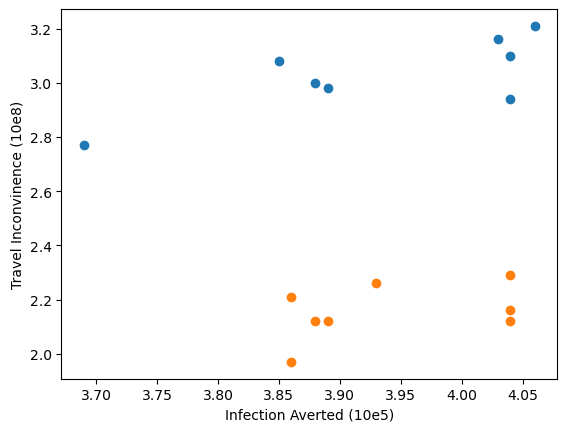

In [25]:
ia = np.array([3.69,3.86,4.03,3.93,4.06,4.04,4.04,4.04,3.89,3.88,4.04,4.04,3.88,3.89,3.85,3.86])
ti = np.array([2.77,1.97,3.16,2.26,3.21,2.29,2.94,2.12,2.98,2.12,3.1,2.16,3,2.12,3.08,2.21])
import matplotlib.pyplot as plt
ia1 = [ia[i] for i in range(0,len(ia),2)]
ia2 = [ia[i] for i in range(1,len(ia),2)]
ti1 = [ti[i] for i in range(0,len(ti),2)]
ti2 = [ti[i] for i in range(1,len(ti),2)]

plt.scatter(ia1, ti1)
plt.scatter(ia2, ti2)
plt.xlabel("Infection Averted (10e5)")
plt.ylabel("Travel Inconvinence (10e8)")
plt.show()

In [22]:
for i in range(0,len(ia),2):
    print(i)

0
2
4
6
8
10
12
14
